# 🍃 Leaf Detection Model using YOLOv8

Welcome to the **Leaf Detection** project!  
This notebook documents the full pipeline for training and evaluating a computer vision model to detect leaves in natural environments using the **YOLOv8** object detection framework.

---

📁 **Dataset**: Leaf Detection Dataset from [Kaggle](https://www.kaggle.com)  
🧠 **Model**: YOLOv11n (You Only Look Once - Version 11)  
🔧 **Framework**: PyTorch & Ultralytics YOLOv8  
🎯 **Goal**: Detect and localize individual tree leaves in images for further analysis in agriculture and environmental research.

---

> 📌 *This project involves preprocessing, training, validation, testing, and visualization of results. Scroll down to explore each phase step by step!*

---


In [1]:
import os
import torch
import ultralytics
import pandas as pd
from ultralytics import YOLO
from ultralytics.utils import ops
import sklearn
from sklearn.model_selection import train_test_split
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
df=pd.read_csv('dataset//train.csv')
df.head()
print(df.head())
# print(df.shape)
p=df.columns
# print(p[1])   

        image_id  width  height                  bbox
0  LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1  LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2  LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3  LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4  LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]


In [3]:
coluns_names=[i for i in df.columns]


annotations=pd.read_csv('dataset//train.csv',names=coluns_names,header=0)
df=pd.DataFrame(annotations)
print(df.head())

        image_id  width  height                  bbox
0  LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1  LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2  LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3  LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4  LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]


In [4]:
unique_filenames = df['image_id'].unique()
train_filenames, val_filenames = train_test_split(unique_filenames, test_size=0.3, random_state=42)

In [5]:
val_filenames,test_filenames = train_test_split(val_filenames, test_size=0.5, random_state=42)

val_df= df[df['image_id'].isin(val_filenames)]
test_df= df[df['image_id'].isin(test_filenames)]
train_df= df[df['image_id'].isin(train_filenames)]

print("Elementos de train_df:",len(train_df["image_id"].unique()))
print(train_df.head())

Elementos de train_df: 791
        image_id  width  height                  bbox
0  LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1  LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2  LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3  LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4  LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]


### Creating YAML file

In [ ]:
output_dir="data"
yaml_filename = "dataset.yaml"
yaml_data = {
    'train': os.path.join(output_dir, 'train'),
    'val': os.path.join(output_dir, 'val'),
    'test': os.path.join(output_dir, 'test'),
    'nc': 1,
    'names': ['leaf']

}

yaml_lines=[]
for key, value in yaml_data.items():
    if key=="format":
        if value=="line_break":
            yaml_lines.append('')
    elif isinstance(value, list):
        yaml_lines.append(f"{key}:{value}")
    else:
        yaml_lines.append(f"{key}: {value}")
yaml_content = '\n'.join(yaml_lines)


output_path = os.path.join(output_dir, yaml_filename)
os.makedirs(output_dir, exist_ok=True)
with open(output_path, 'w') as f:
    f.write(yaml_content)
print(f"YAML file saved to {output_path}")

## Split Dataset to Train , validate and Test

In [7]:
def move_images(df, source_dir, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    unique_filenames = df['image_id'].unique()
    for filename in unique_filenames:
        source_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(dest_dir, filename)
        if os.path.exists(source_path):
            shutil.copy(source_path, dest_path)
        else:
            print(f"File {filename} does not exist in {source_dir}")
    print(f"Moved {len(unique_filenames)} images to {dest_dir}")

In [8]:
def convert_bbox_to_yolo(x,y,width,height,image_width,image_height):
    x_center = (x + width / 2) / image_width
    y_center = (y + height / 2) / image_height
    width_yolo = width / image_width
    height_yolo = height / image_height
    return [x_center, y_center, width_yolo, height_yolo]

In [9]:
def dataframe_to_yolo_format(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data={}
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = row['width']
        img_height = row['height']
        bbox=eval(row['bbox']) 
        x,y,width,height = bbox
        x_canter,y_center,norm_width,norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
        if image_id not in data:
            data[image_id] = []
        data[image_id].append(f"0 {x_canter:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    for image_id, annotations in data.items():
        output_file = os.path.join(output_dir, os.path.splitext(image_id)[0] + '.txt')
        with open(output_file, 'w') as f:
            for ann in annotations:
                f.write(ann+'\n')
    print(f"Converted {len(data)} images to YOLO format in {output_dir}")

In [10]:
img_path="dataset/train"
output_dir='data' 

txt_files_train=f'{output_dir}/train/labels'
img_files_train=f'{output_dir}/train/images'
move_images(train_df, img_path, img_files_train)
dataframe_to_yolo_format(train_df, txt_files_train)


txt_files_val=f'{output_dir}/val/labels'
img_files_val=f'{output_dir}/val/images'
move_images(val_df, img_path, img_files_val)
dataframe_to_yolo_format(val_df, txt_files_val)


txt_files_test=f'{output_dir}/test/labels'
img_files_test=f'{output_dir}/test/images'
move_images(test_df, img_path, img_files_test)
dataframe_to_yolo_format(test_df, txt_files_test)



Moved 791 images to data/train/images
Converted 791 images to YOLO format in data/train/labels
Moved 169 images to data/val/images
Converted 169 images to YOLO format in data/val/labels
Moved 170 images to data/test/images
Converted 170 images to YOLO format in data/test/labels


### Plot Images with bounding Boxes

In [11]:
def plot_images_with_detections(images_dir, labels_dir, num_images=16, grid_size=(4, 4), figsize=(16, 16)):
    image_files = os.listdir(images_dir)
    image_files.sort()
    images_forshow = image_files[:num_images]
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, image_file in enumerate(images_forshow):
        row = i // grid_size[1]
        col = i % grid_size[1]
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (250, 221, 47), 3)
        axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
    plt.show()

#### Train Image Set

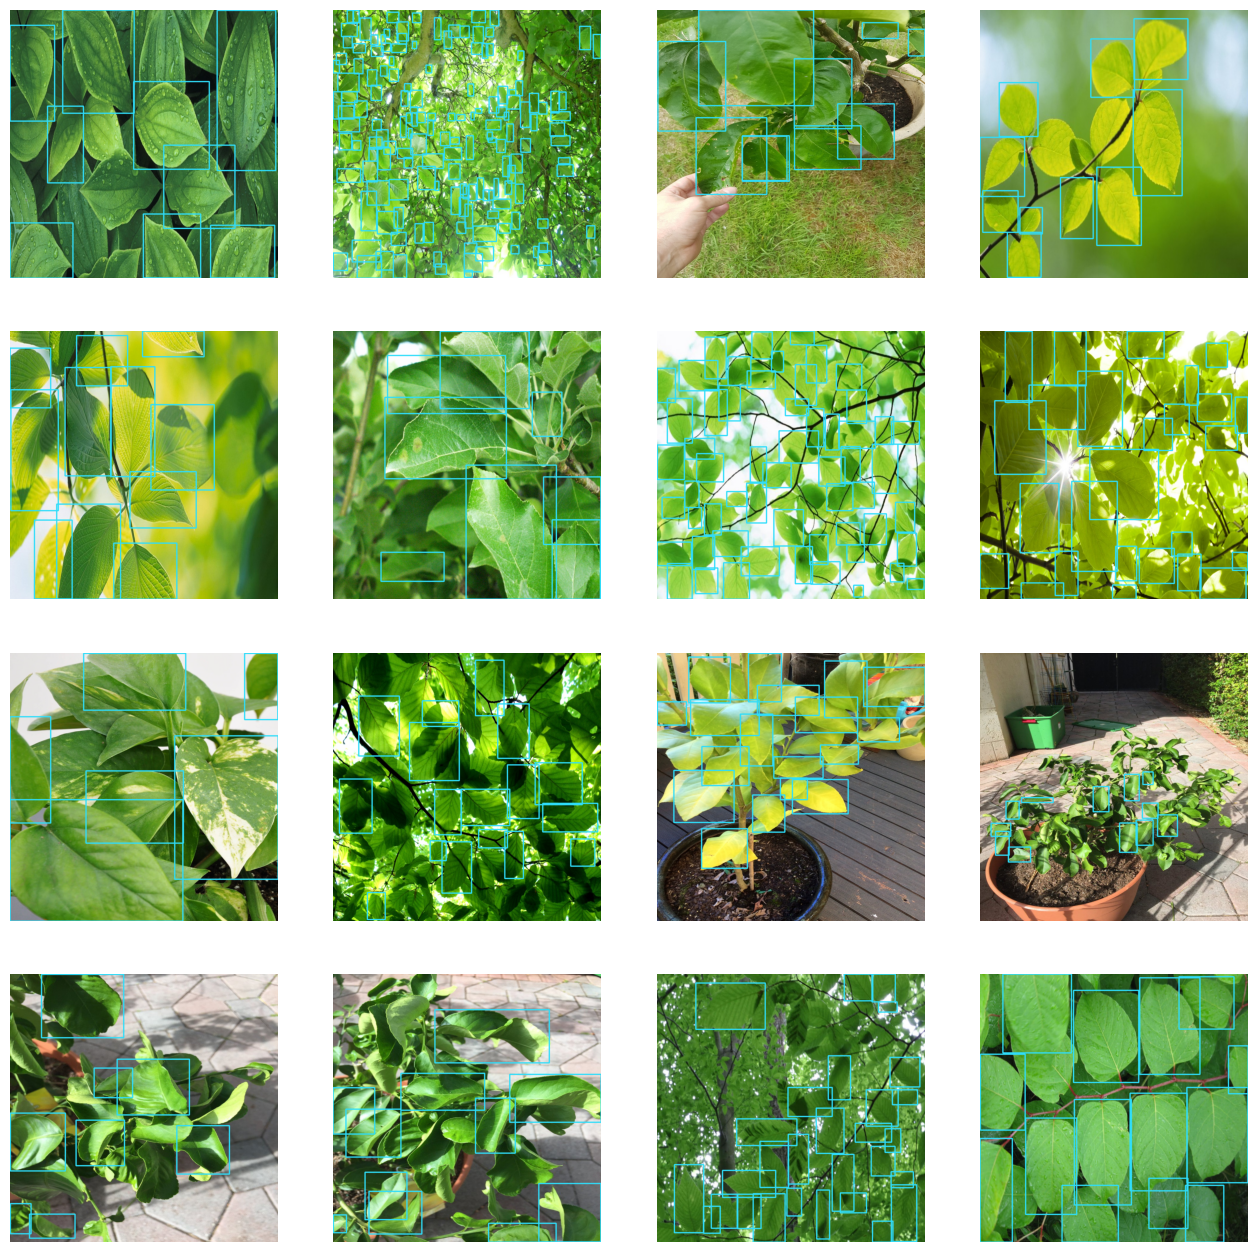

In [20]:
train_images="data//train/images"
train_labels="data//train/labels"

val_images="data//val/images"
val_labels="data//val//labels"

plot_images_with_detections(train_images, train_labels, num_images=16, grid_size=(4, 4), figsize=(16, 16))


#### Validate Image set

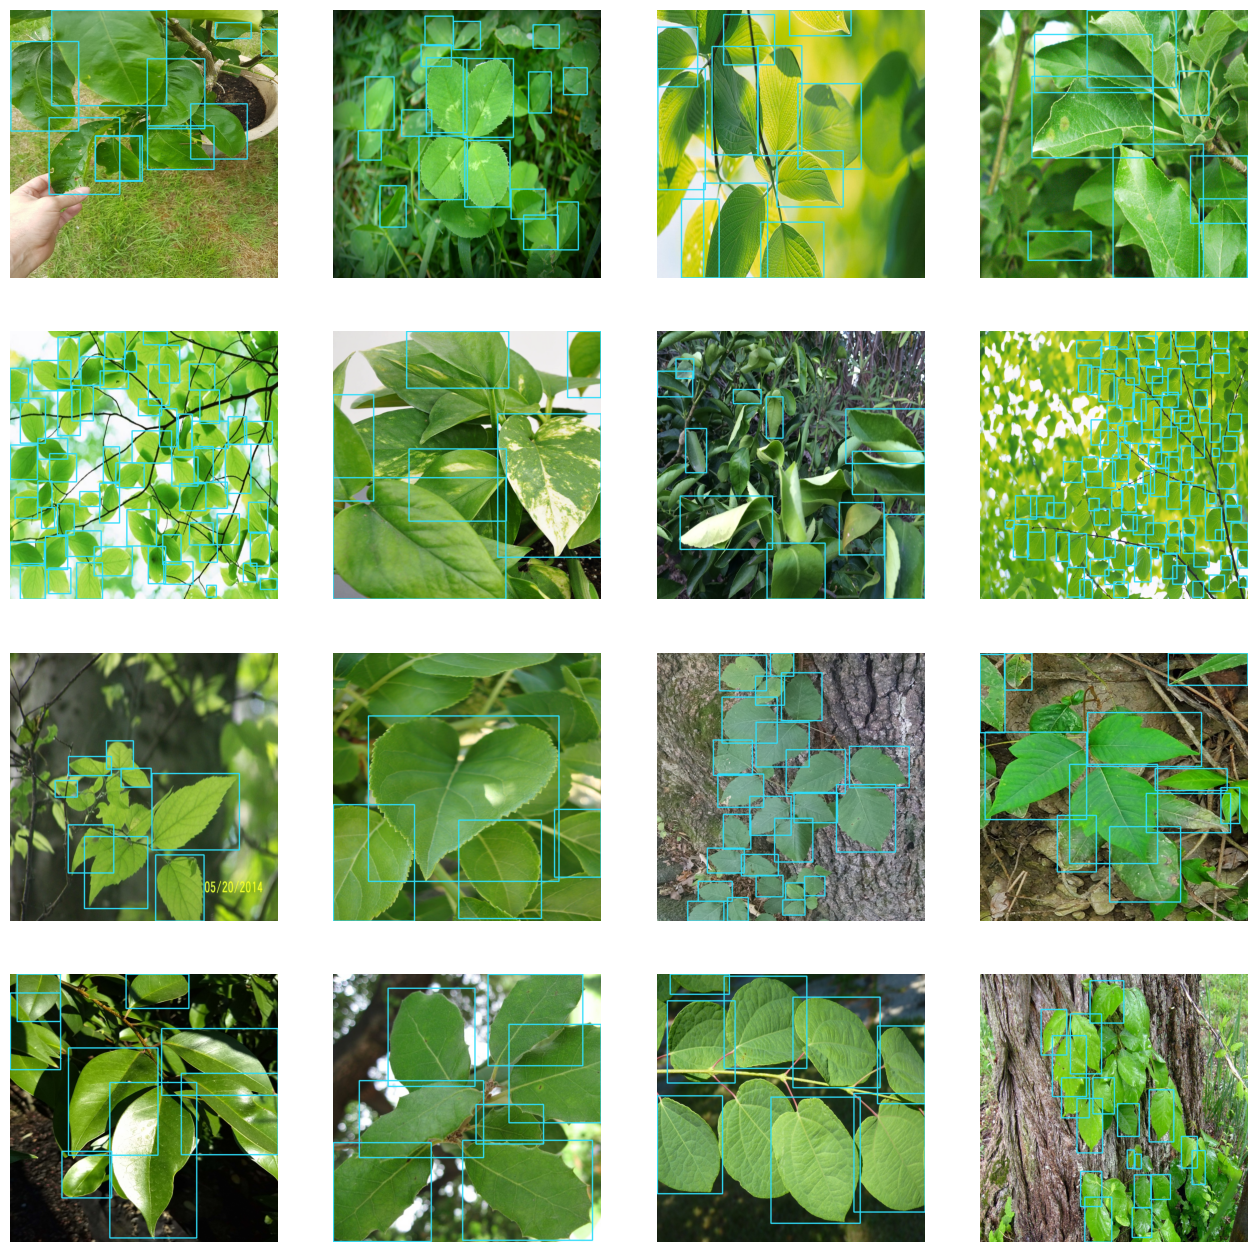

In [21]:
plot_images_with_detections(val_images, val_labels, num_images=16, grid_size=(4, 4), figsize=(16, 16))

#### get the image size and num of channels

In [113]:
image=cv2.imread('data/train/images/leaf_0009.jpg')
cv2.imshow('Leaf Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

height,width,channel = image.shape
print(f"Image dimensions: {height}x{width}, Channels: {channel}")

Image dimensions: 1024x1024, Channels: 3


In [17]:
# Find connected cameras by checking indices
camera_indices = []
for i in range(10):  # Check up to 10 camera indices
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera found at index {i}")
        camera_indices.append(i)
        cap.release()
    else:
        break

if not camera_indices:
    print("No cameras found.")
else:
    print(f"Available camera indices: {camera_indices}")

Camera found at index 0
Available camera indices: [0]


In [19]:
model=YOLO('yolo11n.pt')  # Load the trained YOLOv11 model
if not camera_indices:
    print("No camera found. Please run the camera detection cell above.")
else:
    # Use the first available camera
    cap = cv2.VideoCapture(camera_indices[0])
    
    if not cap.isOpened():
        print(f"Error: Could not open video stream from camera index {camera_indices[0]}")
    else:
        print("Press 'q' to quit the live feed.")
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break

            # Run YOLOv8 inference on the frame
            results = model(frame, verbose=False)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Display the resulting frame
            cv2.imshow('YOLOv8 Live Detection', annotated_frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    # Add a small delay to ensure windows are closed in Jupyter
    for i in range(5):
        cv2.waitKey(1)

Press 'q' to quit the live feed.
